**Load the Libraries**

In [24]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

**Load and Preprocess Images**

In [25]:
def load_images(folder, size=(128, 128)):
    images, filenames = [], []
    for fn in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, fn))
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img.astype('float32') / 255.0)
            filenames.append(fn)
    return np.array(images), filenames

images, filenames = load_images("/content/used_smartphone_images", size=(128, 128))

**Define the Convolutional Autoencoder**

In [26]:
input_img = layers.Input(shape=(128, 128, 3))

# Encoder
x = layers.Conv2D(32, 3, activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D(2, padding='same')(x)   # 64×64×32
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)   # 32×32×64
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D(2, padding='same')(x)  # 16×16×128

# Decoder
x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(encoded)  # 32×32×128
x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)        # 64×64×64
x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)        # 128×128×32
decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)                    # 128×128×3

autoencoder = models.Model(input_img, decoded)

**Complie the model**

In [27]:
autoencoder.compile(optimizer='adam', loss='mse')

**Train the Autoencoder**

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = autoencoder.fit(
    images, images,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop]
)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.1012 - val_loss: 0.0212
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 0.0160 - val_loss: 0.0079
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 0.0069 - val_loss: 0.0056
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.0051 - val_loss: 0.0046
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - loss: 0.0042 - val_loss: 0.0036
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.0022 - val_loss: 0.0021
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 0.0019 - val_loss: 0.0020
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 0.0018 - val_lo

**Compute Reconstruction Errors**

In [29]:
reconstructions = autoencoder.predict(images)
mse = np.mean(np.square(images - reconstructions), axis=(1,2,3))

26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 899ms/step
Reconstruction error (MSE) computed for each image.


**Set Threshold & Classify**

In [30]:
threshold = mse.mean() + 2 * mse.std()
labels = (mse > threshold).astype(int)  # 1 = scratched, 0 = clean

df_results = pd.DataFrame({
    "Filename": filenames,
    "ReconstructionError": mse,
    "Label": labels
})
df_results.to_csv("autoencoder_results.csv", index=False)
print(f"Threshold = {threshold:.4f}. Results saved to autoencoder_results.csv")

Threshold = 0.0013. Results saved to autoencoder_results.csv


**Visualize Examples**

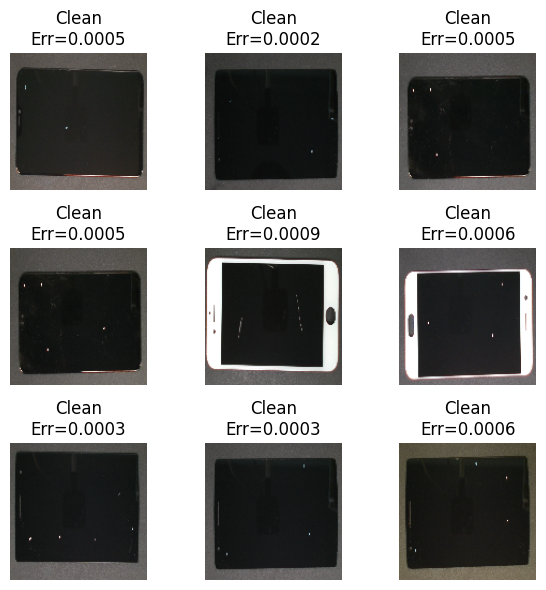

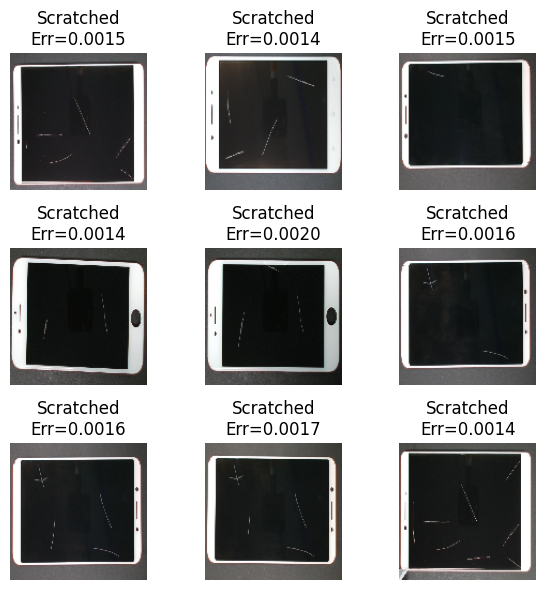

In [34]:
def show_examples(class_id, title):
    idxs = np.where(labels == class_id)[0][:9]
    plt.figure(figsize=(6,6))
    for i, idx in enumerate(idxs):
        plt.subplot(3,3,i+1)
        plt.imshow(images[idx])
        plt.title(f"{title}\nErr={mse[idx]:.4f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_examples(0, "Clean")
show_examples(1, "Scratched")